In [136]:
# imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn import svm
from sklearn.metrics import accuracy_score
import seaborn as sns

In [137]:
from google.colab import files
uploaded = files.upload()

Saving oasis_longitudinal.csv to oasis_longitudinal (2).csv


In [138]:
# Data reading
alz_df=pd.read_csv("oasis_longitudinal.csv")
alz_df.head(10)

,Subject ID,MRI ID,Group,Visit,MR Delay,M/F,Hand,Age,EDUC,SES,MMSE,CDR,eTIV,nWBV,ASF
0,OAS2_0001,OAS2_0001_MR1,Nondemented,1,0,M,R,87,14,2.0,27.0,0.0,1987,0.696,0.883
1,OAS2_0001,OAS2_0001_MR2,Nondemented,2,457,M,R,88,14,2.0,30.0,0.0,2004,0.681,0.876
2,OAS2_0002,OAS2_0002_MR1,Demented,1,0,M,R,75,12,NaN,23.0,0.5,1678,0.736,1.046
3,OAS2_0002,OAS2_0002_MR2,Demented,2,560,M,R,76,12,NaN,28.0,0.5,1738,0.713,1.010
4,OAS2_0002,OAS2_0002_MR3,Demented,3,1895,M,R,80,12,NaN,22.0,0.5,1698,0.701,1.034
5,OAS2_0004,OAS2_0004_MR1,Nondemented,1,0,F,R,88,18,3.0,28.0,0.0,1215,0.710,1.444
6,OAS2_0004,OAS2_0004_MR2,Nondemented,2,538,F,R,90,18,3.0,27.0,0.0,1200,0.718,1.462
7,OAS2_0005,OAS2_0005_MR1,Nondemented,1,0,M,R,80,12,4.0,28.0,0.0,1689,0.712,1.039
8,OAS2_0005,OAS2_0005_MR2,Nondemented,2,1010,M,R,83,12,4.0,29.0,0.5,1701,0.711,1.032
9,OAS2_0005,OAS2_0005_MR3,Nondemented,3,1603,M,R,85,12,4.0,30.0,0.0,1699,0.705,1.033


# Data Exploration:

In [139]:
# Data preprocessing
## Removing duplicates
alz_df=alz_df.drop_duplicates()
## Handling Null Values
alz_df.isnull().sum()

Subject ID     0
MRI ID         0
Group          0
Visit          0
MR Delay       0
M/F            0
Hand           0
Age            0
EDUC           0
SES           19
MMSE           2
CDR            0
eTIV           0
nWBV           0
ASF            0
dtype: int64

In [140]:
alz_df["SES"].fillna(alz_df["SES"].median(), inplace=True)
alz_df["MMSE"].fillna(alz_df["MMSE"].mean(), inplace=True)
alz_df.isnull().sum()

Subject ID    0
MRI ID        0
Group         0
Visit         0
MR Delay      0
M/F           0
Hand          0
Age           0
EDUC          0
SES           0
MMSE          0
CDR           0
eTIV          0
nWBV          0
ASF           0
dtype: int64

In [141]:
## Statistcs of the dataset
alz_df.describe()

,Visit,MR Delay,Age,EDUC,SES,MMSE,CDR,eTIV,nWBV,ASF
count,373.000000,373.000000,373.000000,373.000000,373.000000,373.000000,373.000000,373.000000,373.000000,373.000000
mean,1.882038,595.104558,77.013405,14.597855,2.436997,27.342318,0.290885,1488.128686,0.729568,1.195461
std,0.922843,635.485118,7.640957,2.876339,1.109307,3.673329,0.374557,176.139286,0.037135,0.138092
min,1.000000,0.000000,60.000000,6.000000,1.000000,4.000000,0.000000,1106.000000,0.644000,0.876000
25%,1.000000,0.000000,71.000000,12.000000,2.000000,27.000000,0.000000,1357.000000,0.700000,1.099000
50%,2.000000,552.000000,77.000000,15.000000,2.000000,29.000000,0.000000,1470.000000,0.729000,1.194000
75%,2.000000,873.000000,82.000000,16.000000,3.000000,30.000000,0.500000,1597.000000,0.756000,1.293000
max,5.000000,2639.000000,98.000000,23.000000,5.000000,30.000000,2.000000,2004.000000,0.837000,1.587000


In [142]:
alz_df['Group'].value_counts()

Group
Nondemented    190
Demented       146
Converted       37
Name: count, dtype: int64

In [143]:
alz_df['Group'] = alz_df['Group'].replace(['Converted'], ['Demented'])
alz_df['Group'].value_counts()

Group
Nondemented    190
Demented       183
Name: count, dtype: int64

In [144]:
alz_df = alz_df.loc[alz_df['Visit']==1] # Since all patients are diagnosed in the first visit intially and remain as such
alz_df = alz_df.reset_index(drop=True)


In [145]:
# Labels encoding and Handling Categorical Features
alz_df['Group'] = alz_df['Group'].replace(['Demented', 'Nondemented'], [1,0])
alz_df['M/F']=alz_df['M/F'].replace(['M','F'],[1,0])
alz_df = alz_df.drop(['Subject ID','MRI ID', 'Visit', 'Hand','MR Delay'], axis=1) # Drop irrelevant columns
alz_df.head(5)


,Group,M/F,Age,EDUC,SES,MMSE,CDR,eTIV,nWBV,ASF
0,0,1,87,14,2.0,27.0,0.0,1987,0.696,0.883
1,1,1,75,12,2.0,23.0,0.5,1678,0.736,1.046
2,0,0,88,18,3.0,28.0,0.0,1215,0.710,1.444
3,0,1,80,12,4.0,28.0,0.0,1689,0.712,1.039
4,1,1,71,16,2.0,28.0,0.5,1357,0.748,1.293


In [146]:
alz_df['Group'].value_counts()

Group
1    78
0    72
Name: count, dtype: int64

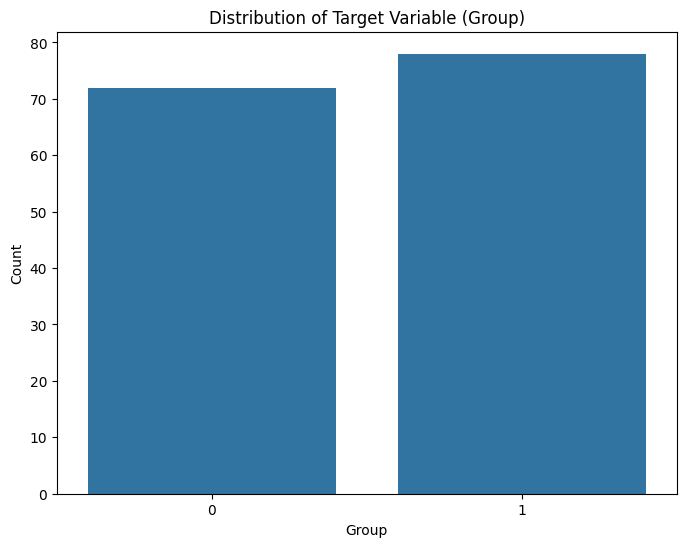

In [147]:
# Distribution of Target Variable (Group)
plt.figure(figsize=(8, 6))
sns.countplot(data=alz_df, x='Group')
plt.title('Distribution of Target Variable (Group)')
plt.xlabel('Group')
plt.ylabel('Count')
plt.show()

This shows that dataset is almost balanced

In [148]:
def remove_outliers(data):
    quartile_1, quartile_3 = np.percentile(data, [25, 75])
    iqr = quartile_3 - quartile_1
    lower_bound = quartile_1 - (iqr * 1.5)
    upper_bound = quartile_3 + (iqr * 1.5)
    clean_data = data[(data > lower_bound) & (data < upper_bound)]
    return clean_data


In [149]:
features = ['EDUC', "SES", "MMSE", 'eTIV', "nWBV", "ASF"]
for feature in features:
    alz_df[feature]=remove_outliers(alz_df[feature])


In [150]:
alz_df.isnull().sum()

Group    0
M/F      0
Age      0
EDUC     2
SES      3
MMSE     6
CDR      0
eTIV     3
nWBV     1
ASF      0
dtype: int64

In [151]:
mean_EDUC = alz_df['EDUC'].mean()
mean_SES = alz_df['SES'].mean()
mean_MMSE = alz_df['MMSE'].mean()
mean_eTIV = alz_df['eTIV'].mean()
mean_nWBV = alz_df['nWBV'].mean()

alz_df['EDUC'].fillna(mean_EDUC, inplace=True)
alz_df['SES'].fillna(mean_SES, inplace=True)
alz_df['MMSE'].fillna(mean_MMSE, inplace=True)
alz_df['eTIV'].fillna(mean_eTIV, inplace=True)
alz_df['nWBV'].fillna(mean_nWBV, inplace=True)

In [152]:

alz_df.isnull().sum()


Group    0
M/F      0
Age      0
EDUC     0
SES      0
MMSE     0
CDR      0
eTIV     0
nWBV     0
ASF      0
dtype: int64

In [160]:
y = alz_df['Group']
x=alz_df.drop('Group',axis=1)
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.35, random_state=42)

# Model


In [161]:
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

# Create a pipeline with scaling and SVM
svm_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('svm', SVC())
])

# Define the parameter grid to search
param_grid = {
    'svm__kernel': ['linear', 'rbf', 'poly'],
    'svm__C': [0.1, 1, 10, 100],
    'svm__gamma': ['scale', 'auto']
}

# Perform grid search with cross-validation
grid_search = GridSearchCV(svm_pipeline, param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid_search.fit(X_train, y_train)

# Print the best parameters and best score
print("Best Parameters:", grid_search.best_params_)
print("Best Score:", grid_search.best_score_)

# Evaluate the best model on the test set
best_model = grid_search.best_estimator_
test_accuracy = best_model.score(X_test, y_test)
print("Test Accuracy:", test_accuracy)

Best Parameters: {'svm__C': 0.1, 'svm__gamma': 'scale', 'svm__kernel': 'linear'}
Best Score: 0.9278947368421052
Test Accuracy: 0.8867924528301887
